<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/0922(%EA%B8%88)_%EA%B3%BC%EC%A0%9C_%EC%95%99%EC%83%81%EB%B8%94_%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EC%8A%A4%ED%84%B0%EB%94%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0922(금) 과제_앙상블_캐글 필사 스터디

### 2129014 박지현
#### 캐글 필사 링크 : https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

# Titanic Top 4% with ensemble modeling
- 사용 데이터 : 타이타닉 데이터
- voting procedure을 통해 타이타닉의 생존 예측하기

## 1. Introduction
- 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data
- 데이터 불러오기

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection
- Outlier 찾기

In [3]:
# Outlier detection

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers
    according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v>n )

    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

> 이상치 찾기
 - 이상치는 예측에 극단적인 영향을 미침
 - Tukey method 사용
  - IQR : Q3 - Q1
  - outlier step : Q1 - 1.5*IQR / Q3 + 1.5*IQR

- numerical values features : "Age","SibSp","Parch","Fare" 에서 outlier 찾기
 - 적어도 2개 이상의 이상치에 속하는 numerical values가 있는 'outliers' 찾기

In [4]:
train.loc[Outliers_to_drop]   # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


> 결과 : 10개의 outliers가 존재
 - 28, 89, 342 passenger : high Ticket Fare
 - 나머지 7명 : high values of SibSP

- 이상치 drop하기

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

> categorical conversion을 위해 train과 test datasets을 합친 것 (features의 같은 숫자를 얻기 위함)

### 2.4 check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

> 'Age', 'Cabin' : missing values가 많다!

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

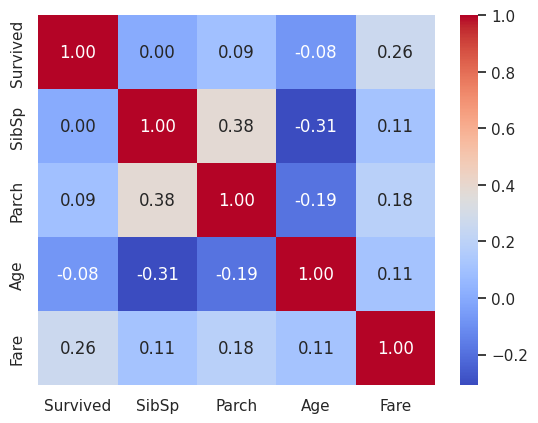

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(),
                annot = True, fmt = ".2f", cmap = "coolwarm")

> 'Fare' 특성 : 'survival probability'와 분명한 상관관계가 있음

- 다른 특성들 좀 더 살펴보기
 - 다른 특성들의 집합들이 survival에 영향을 미쳤을 수도 있기 때문임

#### SibSP

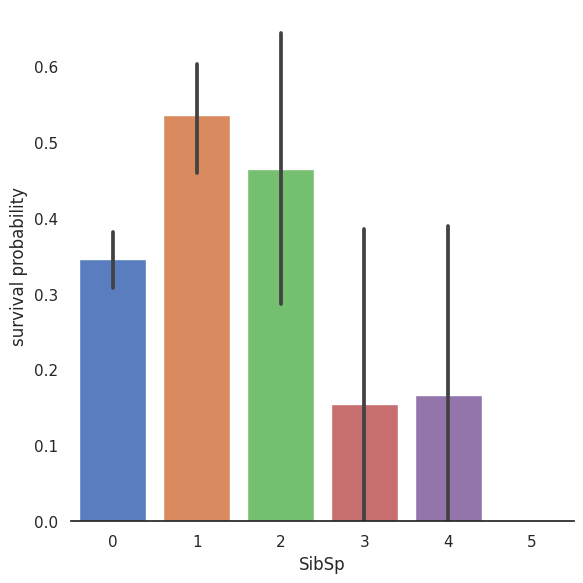

In [13]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> 요약:
 - 형제자매가 많을수록 살아남을 확률이 적다.
 - 외동이거나, 형제자매가 1명, 2명일 때 살아남을 확률이 높다
 - 이 변수를 이용해 새로운 feature을 만드는 것을 고려할 것임 (feature engineering에서 계속됨)

#### Parch

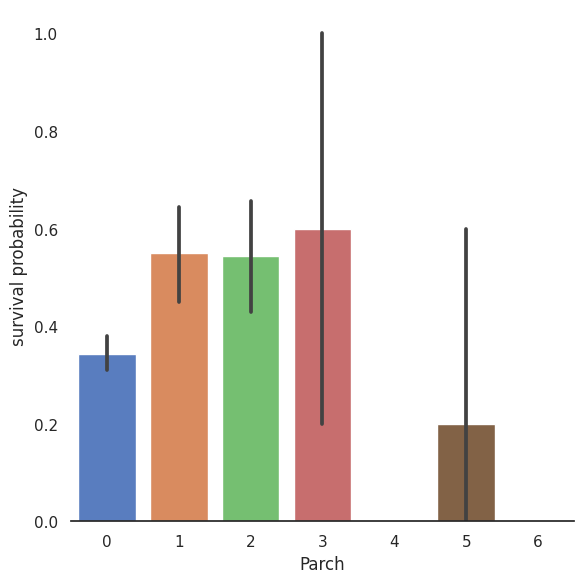

In [14]:
# Explore Parch feature vs Survived
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height = 6,
                palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> 요약:
 - 혼자일 때, 혹은 큰 수의 가족일 때보다 작은 수의 가족이 생존할 확률이 높다.
 - 3명의 가족일 때, 표준 편자가 크다.

#### Age

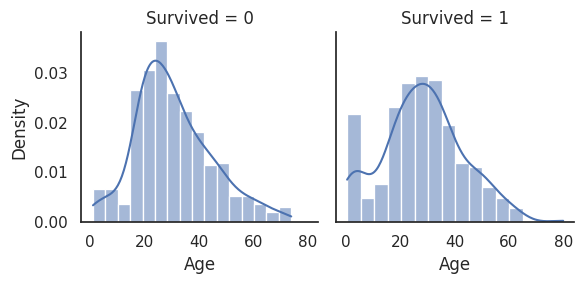

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g.map(sns.histplot, "Age", kde=True, stat="density")

> Age - Survived 요약:
 - 꼬리가 있는 분포이며, 가우시안 분포일 가능성이 있다.
 - Age와 생존확률은 비례하지 않는다.
 - 젊은 생존자일 때 꼭짓점이며, 60-80대일 때 적게 생존한다.
 - 나이가 적음/많음의 카테고리에 따라 생존확률기 높은지 낮은지 달라진다.

- 젊은 승객이 생존확률이 높은 것 같다고 유추 가능하다.

<ipython-input-16-60c53fc48d52>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
<ipython-input-16-60c53fc48d52>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


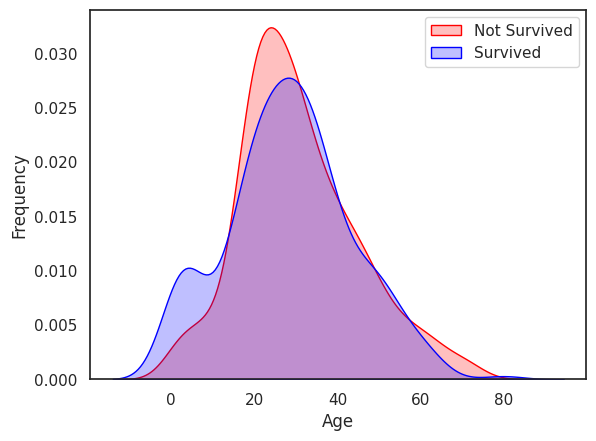

In [16]:
# Explore Age distibution
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

> 요약:
 - 0-5세 사이의 아기와 가장 어린 아이들을 가리키는 생존확률에서 꼭짓점이 있음을 알 수 있다.

#### Fare

- 결측치 처리하기
 - 결측치 개수를 확인하기
  - 결측치를 중앙값으로 채워주기

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

- 'Fare' 분포 살펴보기

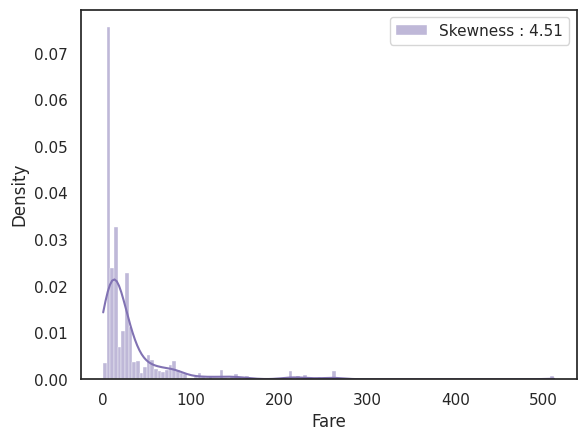

In [19]:
# Explore Fare distribution
g = sns.histplot(dataset["Fare"], color="m", kde=True, stat="density",
                 label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

> 요약:
 - 굉장히 치우쳐져 있는 분포 > 모델에서 큰 값으로 압도할 수 있음
 - 치우쳐짐을 줄이기 위해, log function으로 transform하는 것이 나을 것이다!


- log transformation 적용하기

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

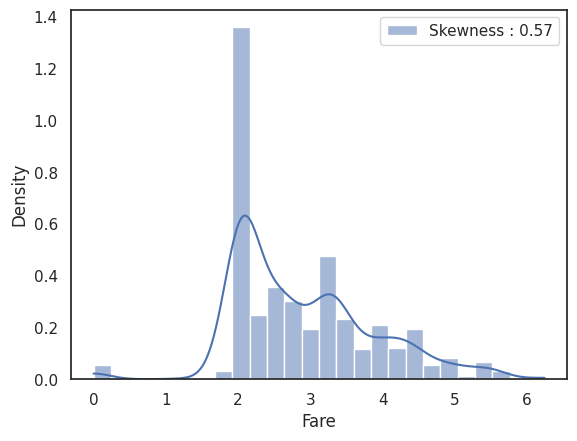

In [21]:
g = sns.histplot(dataset["Fare"], color="b", kde=True, stat="density",
                 label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

> 결과 : log transformation을 적용하면 '치우쳐짐(Skewness)'이 감소한 것을 알 수 있다.

### 3.2 Categorical values

#### Sex

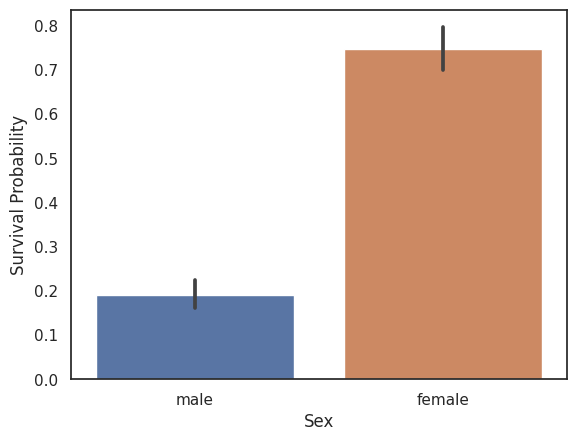

In [22]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g =g.set_ylabel("Survival Probability")

In [23]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


>
 - Male이 Female보다 생존확률이 낮다.
 - 성별이 생존확률이 중요한 역할을 할 수도 있다.

#### Pclass

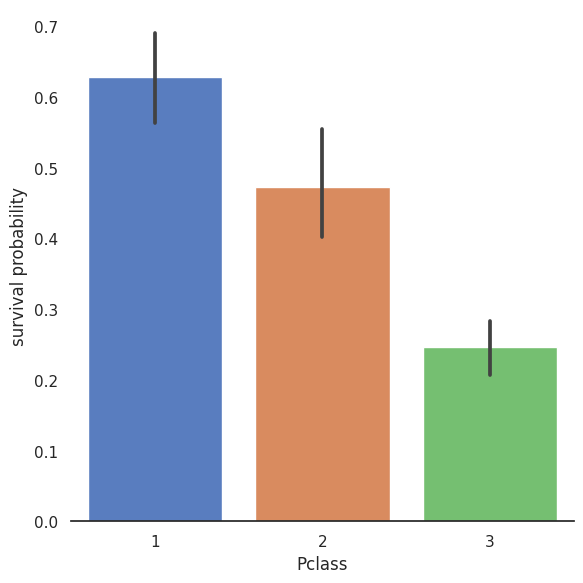

In [24]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar",
                height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

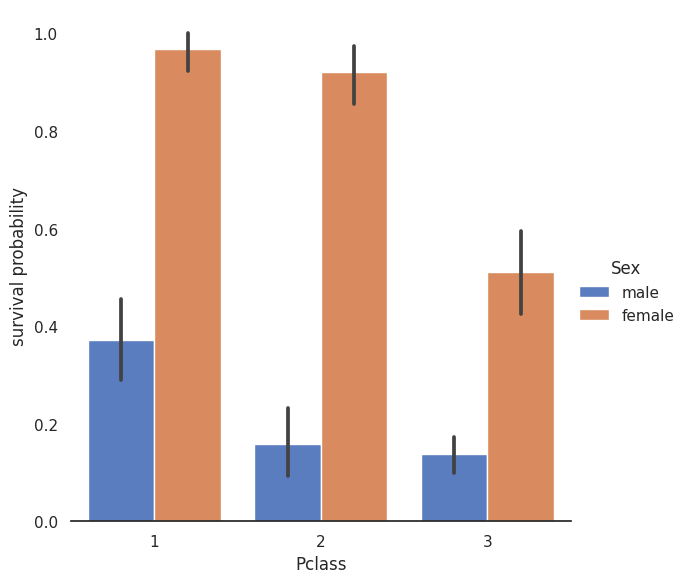

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

>
 - Ticket class : 1 = 1st, 2 = 2nd, 3 = 3rd
 - 3개의 class의 생존 확률이 같지 않다.
 - 2등석, 3등석보다 1등석이 더 살 가능성이 높다. (두 성별 모두에 해당되는 경향)

#### Embarked
- 결측치 처리하기
 - 결측치 개수 확인하기
 - 결측치를 최빈값인 "S"로 채우기

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
# Fill Embarkd nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

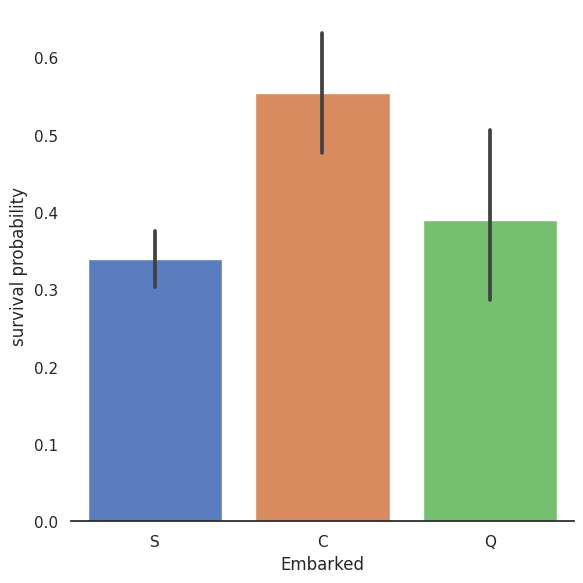

In [28]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked", y="Survived",  data=train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

>
 - Cherbourg(C)에서 온 승객이 생존확률이 높다.

- Pclass distribution vs Embarked 확인하기
 - 가설 : 1등석 승객의 비율은 Cherbourg(C)에서 온 승객이, Queenstown(Q), Southampton(S)보다 높을 것이다.

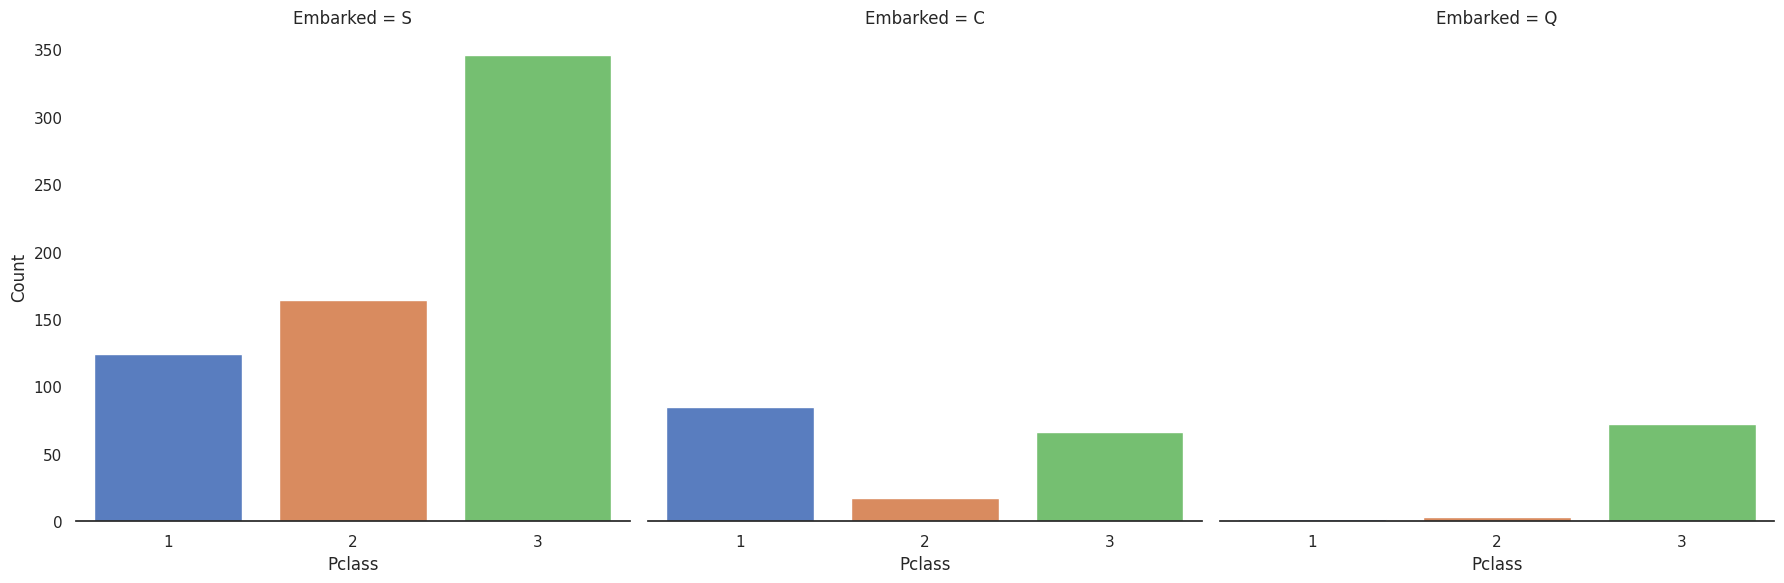

In [29]:
# Explore Pclass vs Embarked
g = sns.catplot(x = "Pclass", col="Embarked",  data=train,
                height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

>
 - 3등석의 비율이 Queenstown(Q), Southampton(S)가 높고, 1등석의 비율은 Cherbourg(C)이 높다.
 - 티켓 class의 영향에 지역에 따른 생존 비율 또한 영향을 미친 것이라 생각할 수 있다.

## Filling missing Values

### 4.1 Age
- 256개의 결측치 존재

- Age와 다른 특징들(Sex, Parch , Pclass and SibSP)이 연관되어 있는지 확인하기

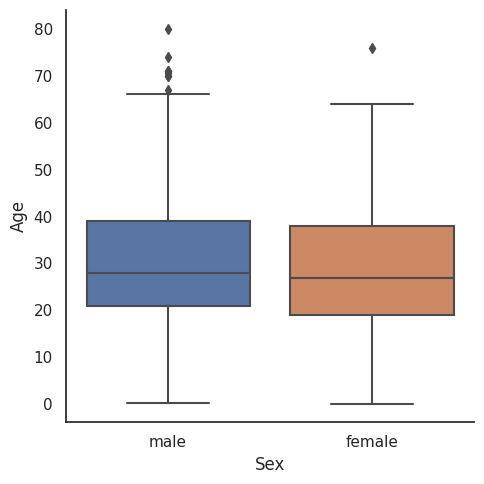

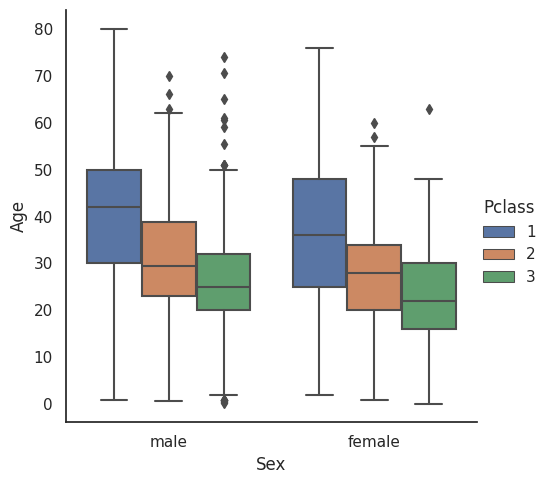

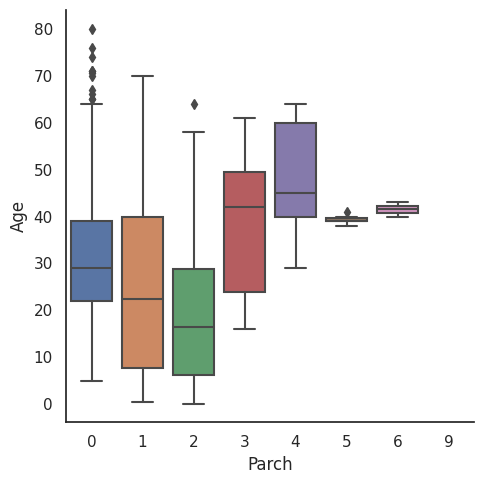

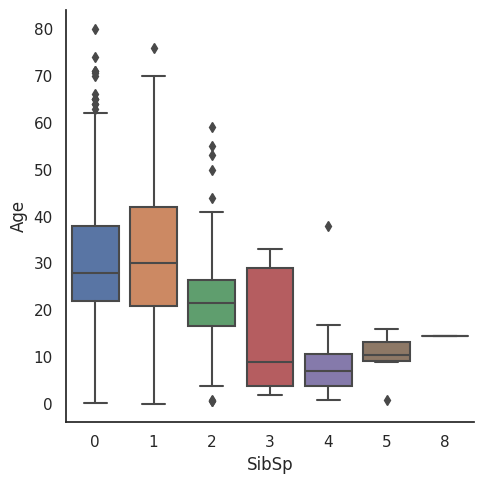

In [30]:
# Explore Age vs Sex, Parch, Pclass and SibSp
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

>
 - 성별에 따라 나이 분포는 달라지지 않는다. > 성별이 나이를 예측하는 데 상관없다.
 - 1등석 승객, 2등석 승객은 3등석 승객보다 나이가 많은 경향이 있다.
 - 승객의 부모/아이가 있을수록, 승객의 나이가 많아지며, 승객이 젊을수록 승객의 형제자매가 있을 가능성이 높다.

In [31]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

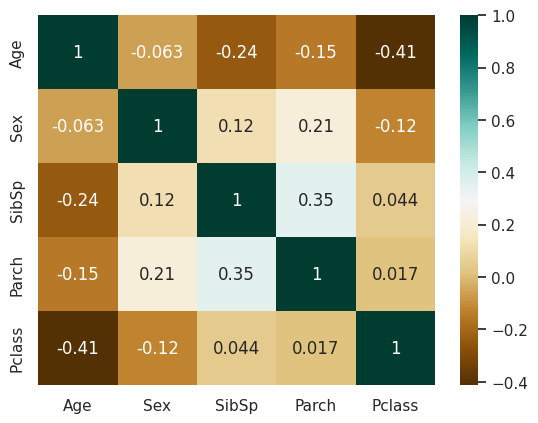

In [32]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),
                cmap="BrBG",annot=True)

>
 - Age와 Sex는 연관이 없고, Pclass/Parch/SibSp와는 음의 상관관계가 있다.
 - SibSP, Parch and Pclass : 나이의 결측치를 채워넣는 데 사용하기로 함

- 나이가 결측치의 열에 Pclass, Parch and SibSp가 비슷한 열들의 나이의 평균을 내어 결측치 자리에 넣기

In [33]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

<ipython-input-33-d8eabb3b919d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-33-d8eabb3b919d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-33-d8eabb3b919d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-33-d8eabb3b919d>:11: SettingWithCopyWarning: 
A value is trying to be set on

- 생존 여부와 age간 더 많은 분포 확인해보기

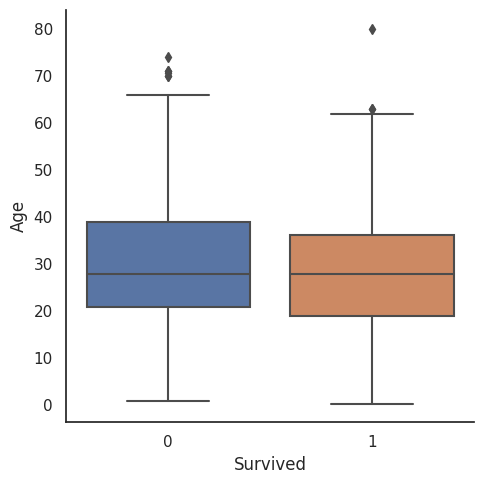

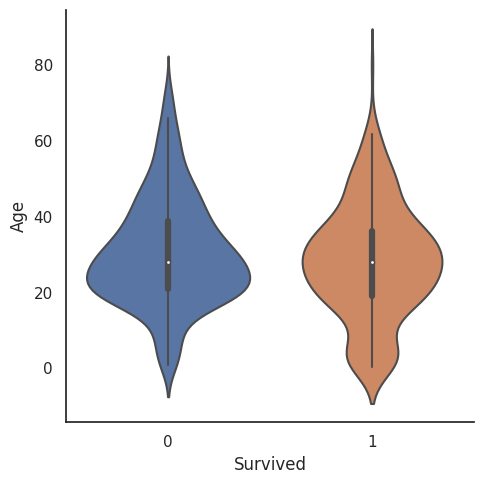

In [34]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

> 결과
 - 생존여부에 따라 중간값의 차이는 없다.
 - 매우 어린 승객들은 높은 생존 확률을 보인다.

## 5. Feature engineering

### 5.1 Name/Title

In [35]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

>
 - 'Name' 특징 : 승객의 제목에 대한 정보를 포함

-  대피 과정에서 신분이 다른 일부 승객(Mr, Mrs, Miss...)이 선호될 수 있기 때문에, 이들을 모델에 추가해보기

1. Name 속성에서 title 분리하기

In [36]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

2. 분리한 title 살펴보기

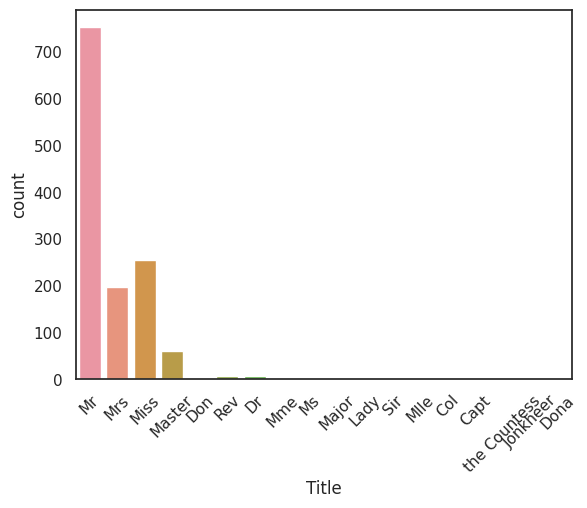

In [37]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

>
 - 17개의 title 존재
 - 대부분의 범주가 드물고, 총 4개의 범주로 묶을 수 있음

3. title을 4개의 범주로 다시 묶어주기
 - 'Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona' : 'Rare'로 묶어주기
 - 'Miss', 'Ms', 'Mme', 'Mlle', 'Mrs' : 하나로 묶어주기

In [38]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

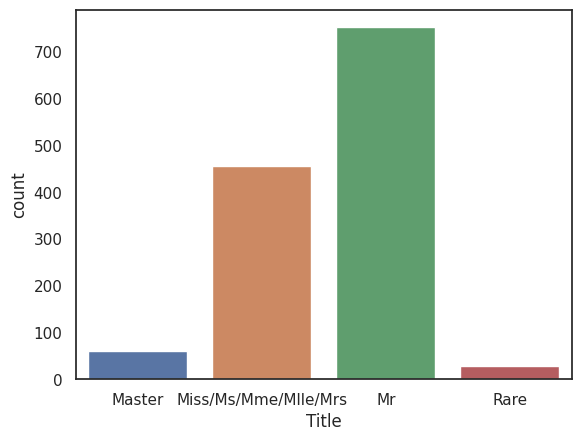

In [39]:
g = sns.countplot(data=dataset, x="Title")
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
plt.show()

- 위의 새로운 4개의 범주에 따른 생조여부의 확률 확인하기

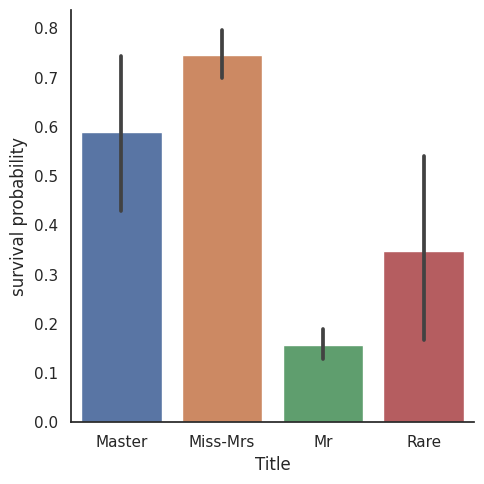

In [40]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

> 결과:
 - "Women and children first" 기준이 적용된 것으로 보임
 - 'rare' title을 가지고 있는 사람이 더 생존확률이 높은 것은 흥미로움

4. 'Name' 변수 drop하기
 - 생존여부에 영향이 갈 만한 요소 모두 추출했기 때문

In [41]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size
- 대피하는 동안 대가족들이 언니/동생/부모님을 찾아 대피하는 데 더 많은 어려움을 겪을 것임을 추측 가능

- SibSp + Parch + 1(승객 본인)을 합한 "Fsize"(가족 규모) 피쳐 생성하기

In [42]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

- 새로 생성한 Fzsize 변수와 생존 확률 간의 꺾은선 그래프 생성하기

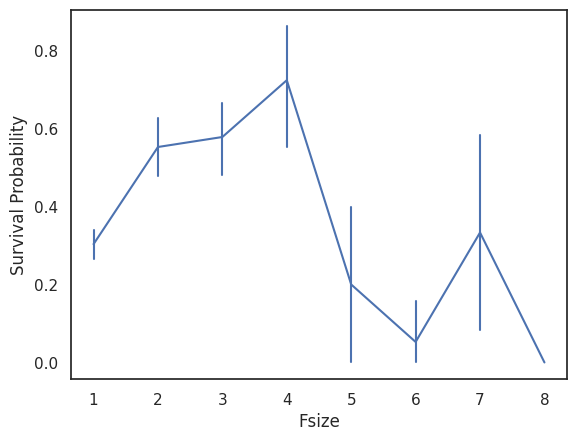

In [43]:
g = sns.lineplot(x="Fsize",y="Survived",data = dataset, err_style='bars')
g = g.set_ylabel("Survival Probability")

>
 - 가족의 크기는 생존확률에 중요한 역할을 하는 것으로 보임
 - 큰 규모의 가족은 생존 확률이 가장 낮다.


- 가족의 크기에 따른 4개의 범주 생성하기

In [44]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

- 범주에 따른 생존확률 그래프로 나타내기

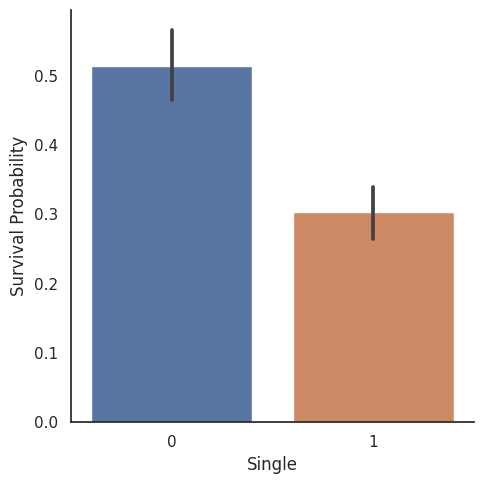

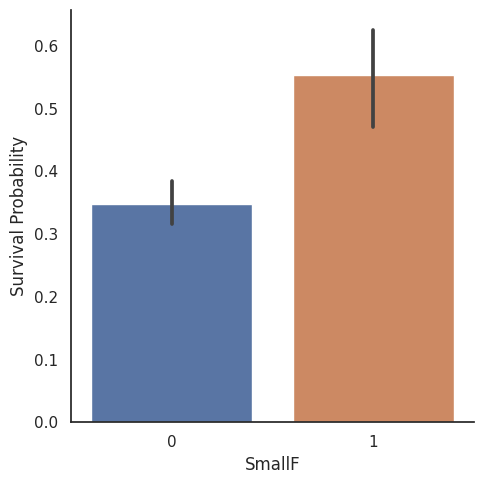

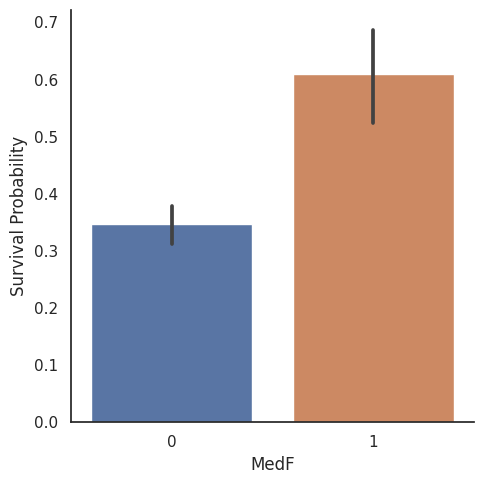

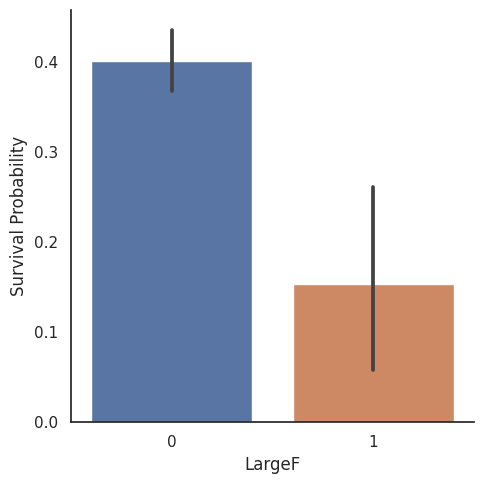

In [45]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

>
 - 작거나 중간 크기의 가족이 혼자거나 큰 크기의 가족이 있는 승객보다 더 높은 생존확률을 가진다.

- Title, Embarked 원핫 인코딩하기

In [46]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


> 결과 : 22개의 features

### 5.3 Cabin

- 변수 살펴보기

In [48]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].isnull().sum()

1007

- 'Cabin' feature : 292개의 values, 1007개의 결측치
> cabin이 없는 승객 : cabin number 대신 결측치가 들어갔을 것이라 가정하자.

- 'Cabin'의 결측치 처리하기
 - 'X'로 결측치 대체하기

In [51]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

객실의 첫번째 글자: 책상을 가리킴 > 타이타닉호에 탑승한 승객의 위치를 나타낼 수 있음
- 객실의 첫 번째 글자만 분리하여 보관하기
 - null일 경우, 'X' 채워넣음

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X'
                              for i in dataset['Cabin'] ])

- 객실의 첫 번째 글자의 개수 그래프로 나타내기

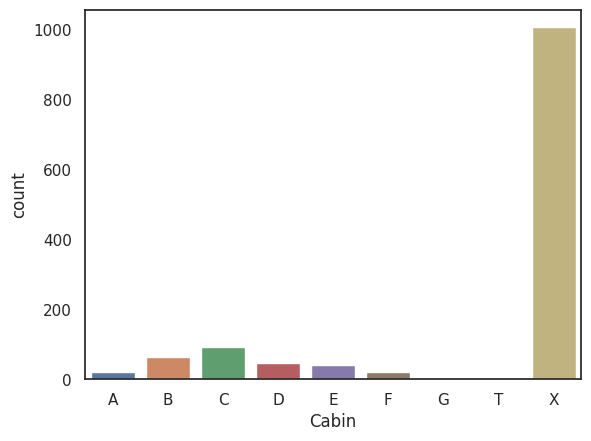

In [53]:
g = sns.countplot(data=dataset, x="Cabin",
                  order=['A','B','C','D','E','F','G','T','X'])

- Cabin 첫 글자에 따른 생존 확률

AttributeError: ignored

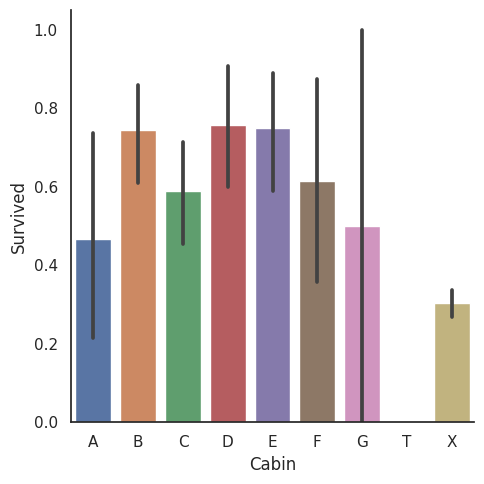

In [54]:
sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",
            order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

>
 - 객실을 보유한 승객의 수가 적기 때문에, 각 객실에 따른 생존 확률의 차이를 신뢰할 수 없음
 - But, 그객실이 있는 승객은 그렇지 않은 승객(X)보다 일반적으로 생존할 기회가 더 많음
  - 특히, 객실 B, C, D, E 및 F의 경우 그러함

- 'Cabin' 원핫 인코딩해주

In [55]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [56]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

>
 - 동일 접두사를 공유하는 표 : 함께 위치한 객실을 예약한 정보일 수 있음 > 실제 선실이 배 내에 배치되는 것으로 이어질 수 있음
 -접두사가 같은 티켓은 등급과 생존율이 비슷할 수 있다.

- Ticket feature을 'ticket prefix'로 대체하기
 - 더욱 정보적임
 - . / 를 삭제하고 띄어쓰기 ' '를 기준으로 나눈 후 앞의 것을 prefix로 하고, 'Ticket' 변수를 대체하기

In [57]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip()
        .split(' ')[0])   #Take prefix
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

- 'Ticket'를 원핫인코딩하기

In [58]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

- numeric이고 결측치가 없는 Pclass를 카테고리컬 변수로 바꾸어주고, 원핫인코딩하기
 - 1등석, 2등석, 3등석의 정보가 담겨 있는 feature

In [59]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

- 필요없는 변수 'PassengerId' 삭제하기
 - 승객 번호 : 구별을 위함

In [60]:
# Drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

- 최종 데이터 확인하기

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. Modeling

- train/test 데이터 분리하기

In [62]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

<ipython-input-62-4ded5fa7d752>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


- features와 label 분리하기

In [63]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

<ipython-input-63-be88970b528a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


### 6.1 Simple modeling

#### 6.1.1 Cross validate models

**- SVC**

In [64]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

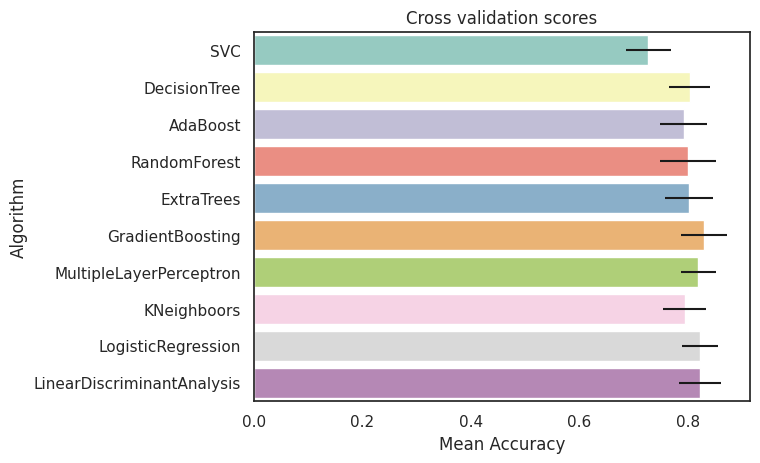

In [65]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res,
                palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

#### 6.1.2 Hyperparameter tunning for best models

In [66]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [67]:
gsadaDTC.best_score_

0.8275536261491316

In [68]:
#ExtraTrees
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297497446373849

In [69]:
# RFC Parameters tunning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793668

In [70]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8331332992849847

In [71]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot learning curves

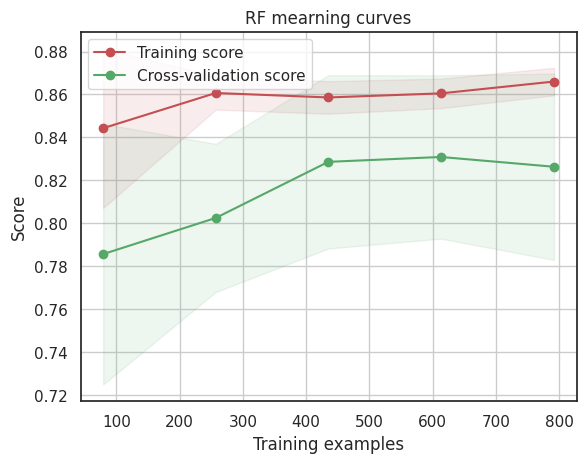

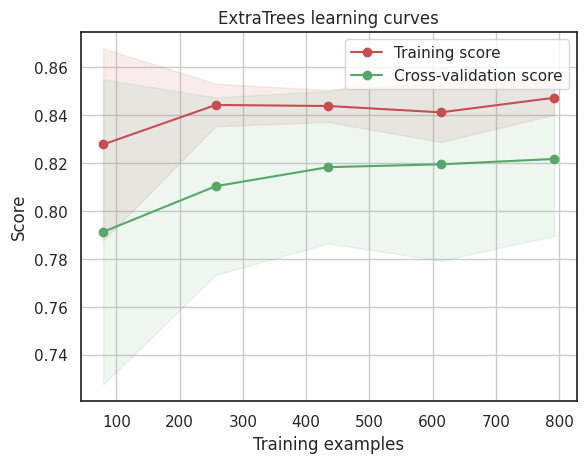

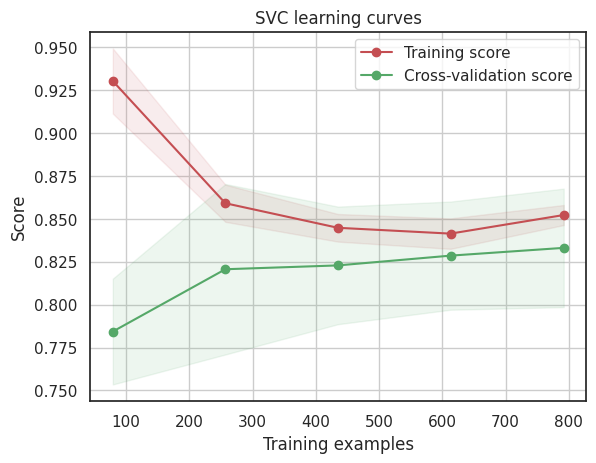

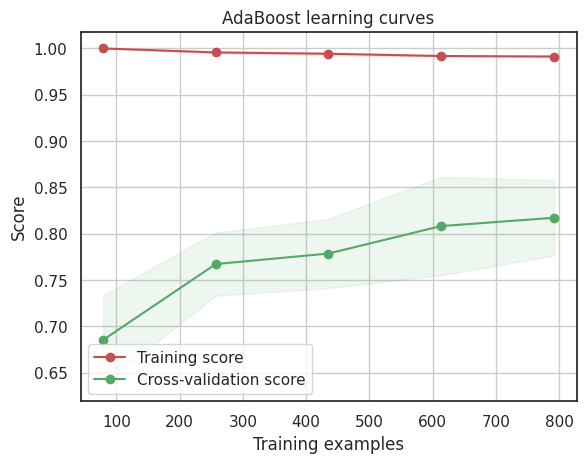

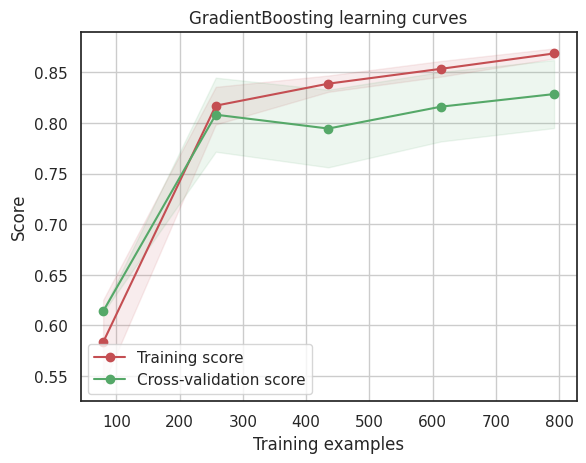

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

#### 6.1.4 Feature importance of tree based classifiers

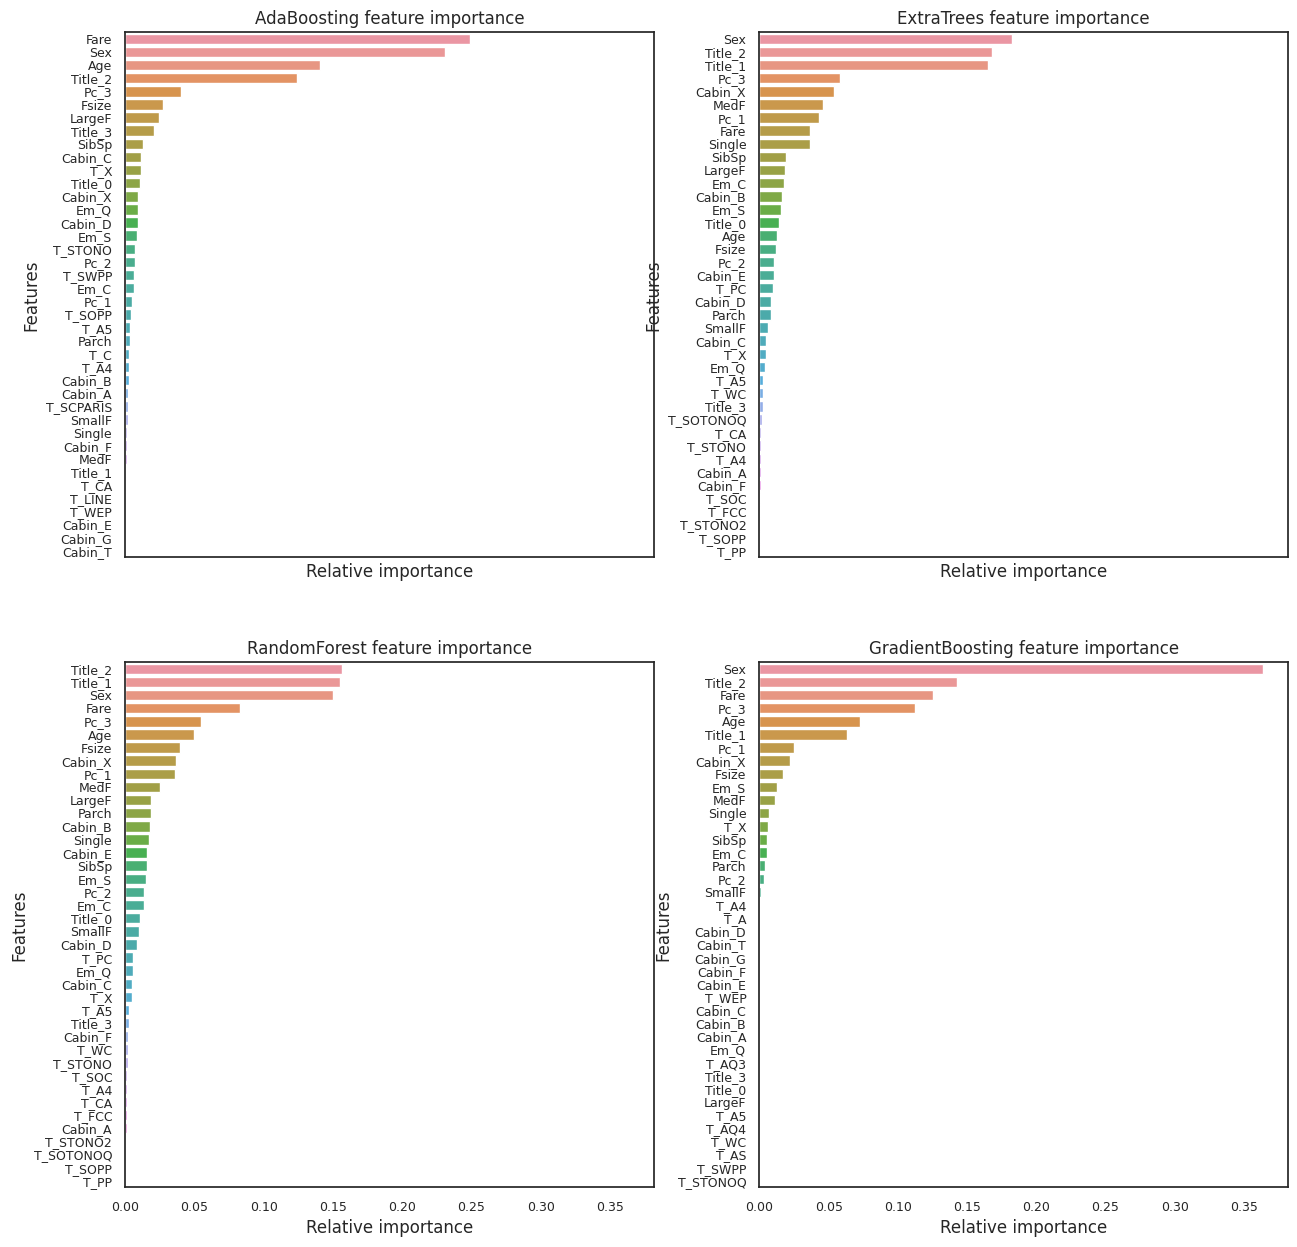

In [73]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

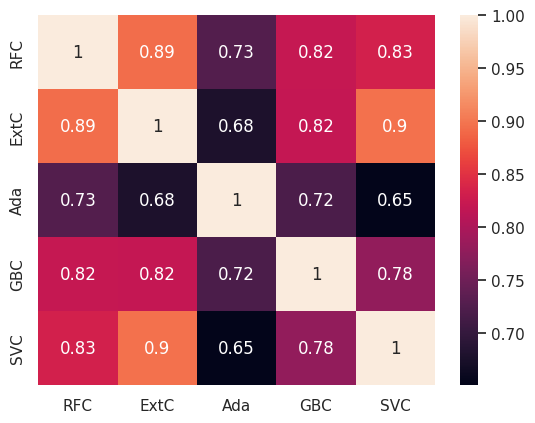

In [74]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

### 6.2 Ensemble modeling

#### 6.2.1 Combining models

In [75]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction

#### 6.3.1 Predict and Submit results

In [76]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

- 최종 제출물 확인하기

In [77]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
